<a href="https://colab.research.google.com/github/SingamSaiVaraPrasad/my_projects/blob/main/cotton_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [47]:
BATCH_SIZE=32
CHANNELS=3
IMAGE_SIZE=256
EPOCHS=50
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/cotton",
    shuffle=True,
    batch_size=32
)

Found 1720 files belonging to 4 classes.


In [48]:
class_names=dataset.class_names
n_classes=len(class_names)
len(dataset)

54

In [49]:
for image_batch,label_batch in dataset.take(1):  # this gives all images in 1 batch and their labels
  print(image_batch.shape)
  print(label_batch.numpy()) # actually label is a tensor, convert to numpy

(32, 256, 256, 3)
[1 0 2 0 2 1 2 2 1 0 3 2 2 3 0 0 0 1 0 2 0 2 0 2 0 2 0 0 0 2 2 0]


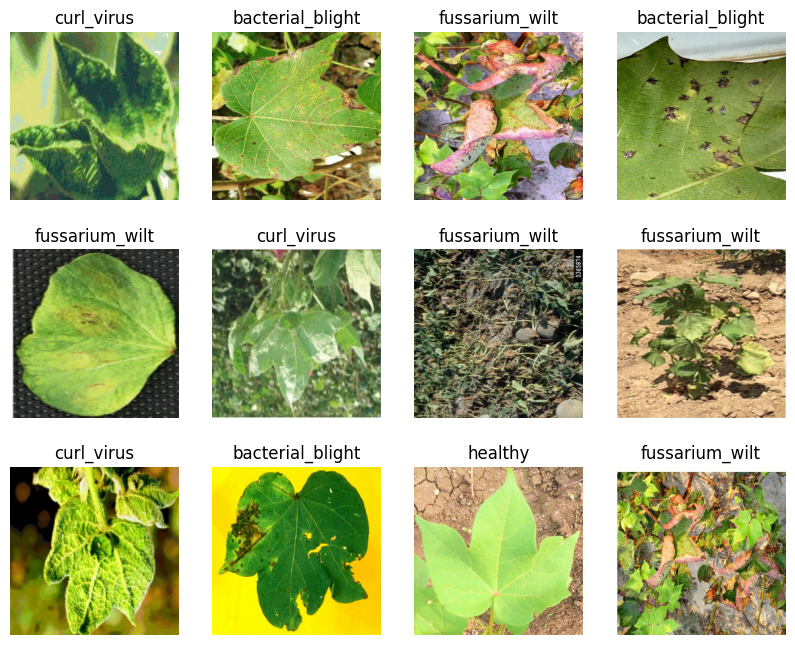

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
for img,lab in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.gca().set_axis_off()

In [51]:
train_sz=0.8
total_sz=len(dataset)
ntrain=int(total_sz*train_sz)
ntest=int((total_sz-ntrain)/2)
nvalid=len(dataset)-ntrain-ntest
print(ntrain,",",ntest,",",nvalid)

train_ds=dataset.take(ntrain) #train
temp=dataset.skip(ntrain)
valid_ds=temp.take(nvalid) #valid
test_ds=temp.skip(nvalid) #test

43 , 5 , 6


In [52]:
# dedicated function
def splitting(ds,train_sz,shuffle=True,shuffle_size=10000):
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  total_sz=len(dataset)
  ntrain=int(total_sz*train_sz)
  ntest=int((total_sz-ntrain)/2)
  nvalid=len(dataset)-ntrain-ntest
  print(ntrain,",",ntest,",",nvalid)

  train_ds=dataset.take(ntrain) #train
  temp=dataset.skip(ntrain)
  valid_ds=temp.take(nvalid) #valid
  test_ds=temp.skip(nvalid) #test
  return train_ds,valid_ds,test_ds

In [53]:
train_ds,valid_ds,test_ds=splitting(ds=dataset,train_sz=0.8)

43 , 5 , 6


In [54]:
train_ds=train_ds.cache().shuffle(600).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(600).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds=valid_ds.cache().shuffle(600).prefetch(buffer_size=tf.data.AUTOTUNE)

In [55]:
# should scale 255 to 0-1 scale of RGB
# this is data augumentation
resized_rescaled=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)]
)

In [56]:
rotated_flipped=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)]
)

In [57]:
# Modeling the model now


In [106]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=4
model = models.Sequential([
    resized_rescaled,
    # Add more preprocessing layers if needed, e.g., rotated_flipped

    layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])


model.build(input_shape=input_shape)

In [107]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, None)    0         
                                                                 
 conv2d_17 (Conv2D)          (32, 256, 256, 32)        896       
                                                                 
 max_pooling2d_17 (MaxPooli  (32, 128, 128, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (32, 128, 128, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPooli  (32, 64, 64, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (32, 64, 64, 128)        

In [108]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [109]:
histt = model.fit(
    train_ds,
    epochs=EPOCHS,  # Adjust the number of epochs as needed
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1  # Set verbose to 1 to see epoch progress line by line
)

Epoch 1/50
43/43 [==============================] - 9s 78ms/step - loss: 1.2881 - accuracy: 0.3430 - val_loss: 1.1057 - val_accuracy: 0.4375
Epoch 2/50
43/43 [==============================] - 3s 66ms/step - loss: 1.0072 - accuracy: 0.5603 - val_loss: 0.9242 - val_accuracy: 0.5938
Epoch 3/50
43/43 [==============================] - 3s 65ms/step - loss: 0.8637 - accuracy: 0.6432 - val_loss: 0.7756 - val_accuracy: 0.6771
Epoch 4/50
43/43 [==============================] - 3s 65ms/step - loss: 0.6246 - accuracy: 0.7544 - val_loss: 0.6040 - val_accuracy: 0.7500
Epoch 5/50
43/43 [==============================] - 3s 72ms/step - loss: 0.4892 - accuracy: 0.8081 - val_loss: 0.6338 - val_accuracy: 0.7188
Epoch 6/50
43/43 [==============================] - 3s 68ms/step - loss: 0.4046 - accuracy: 0.8496 - val_loss: 0.4543 - val_accuracy: 0.8333
Epoch 7/50
43/43 [==============================] - 3s 67ms/step - loss: 0.2646 - accuracy: 0.9077 - val_loss: 0.3538 - val_accuracy: 0.8333
Epoch 8/50
43

In [110]:
histt.params

{'verbose': 1, 'epochs': 50, 'steps': 43}

In [111]:
histt.history.keys()
loss=histt.history['loss']
val_loss=histt.history['val_loss']
acc=histt.history['accuracy']
val_acc=histt.history['val_accuracy']

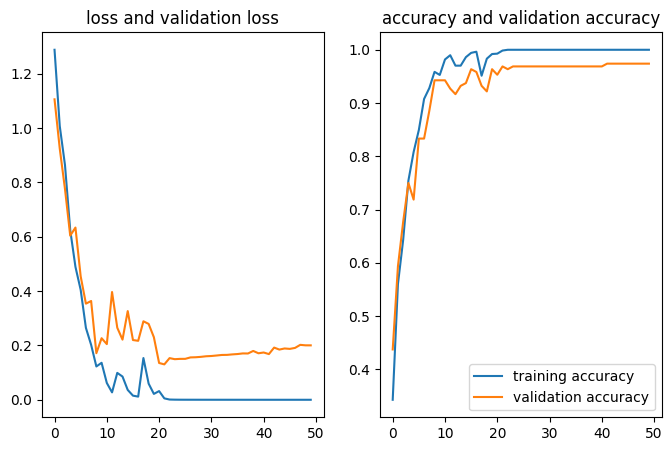

In [113]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='training loss')
plt.plot(range(EPOCHS),val_loss,label='validation loss')
plt.title('loss and validation loss')
# plt.legend(loc='lower right')
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),acc,label='training accuracy')
plt.plot(range(EPOCHS),val_acc,label='validation accuracy')
plt.title('accuracy and validation accuracy')
plt.legend(loc='lower right')

In [ ]:
## this model is ready and we can use this model to predict


original disease is : curl_virus
1/1 [==============================] - 0s 29ms/step
predicted disease is : curl_virus


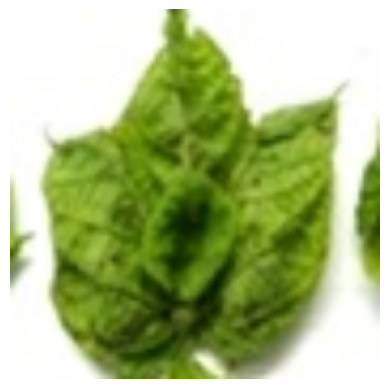

In [118]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
  img=image_batch[0].numpy().astype("uint8")
  plt.imshow(img)
  plt.axis("off")
  print("original disease is :",class_names[label_batch[0]])
  batch_prediction=model.predict(image_batch)
  print("predicted disease is :",class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 0s 25ms/step


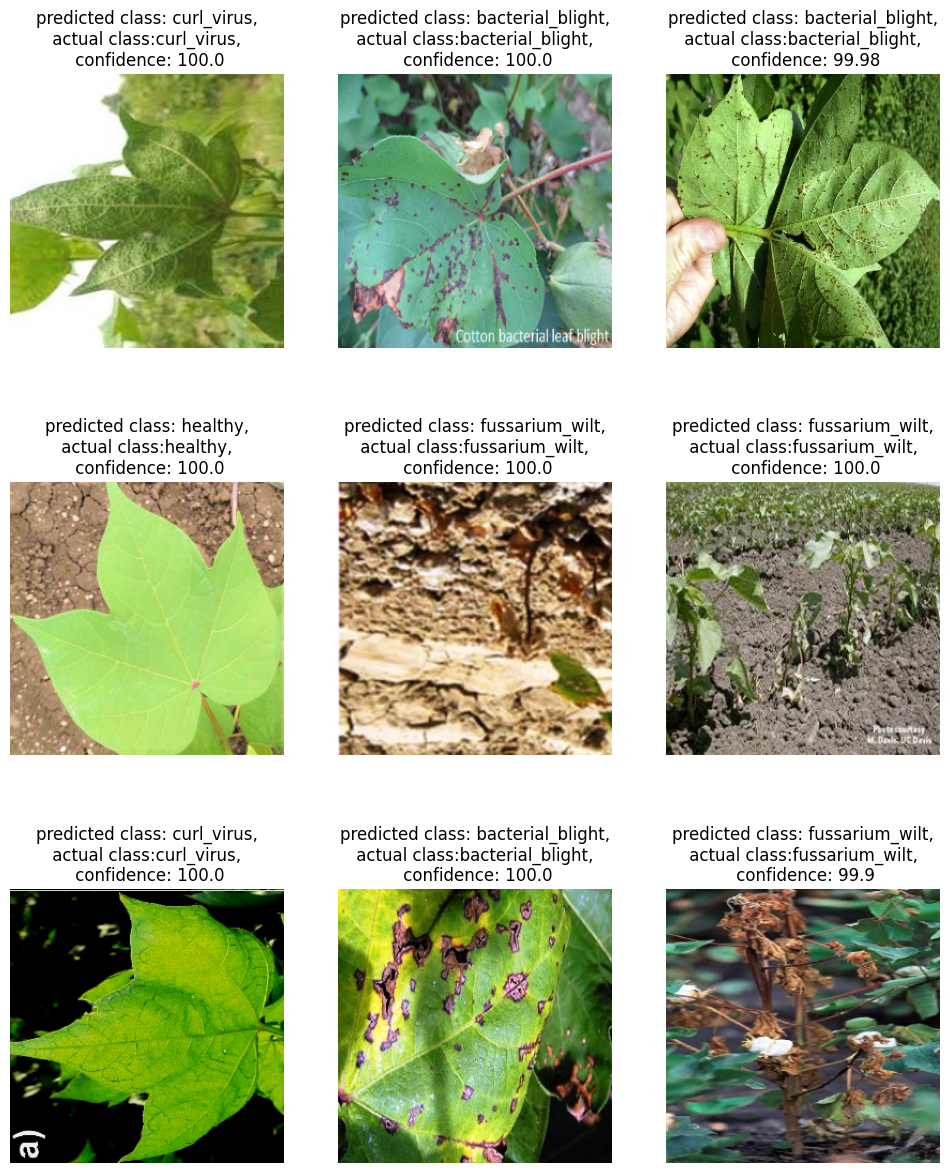

In [129]:
def pred_disease(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0) #create a batch

  predictions=model.predict(img_array)
  pred_cls=class_names[np.argmax(predictions[0])]
  # pred_cls=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return pred_cls,confidence

plt.figure(figsize=(12,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    pred_class,confidence=pred_disease(model,images[i].numpy())
    # plt.title(f"predicted class: {pred_class},\n actual class:{class_names[label_batch[i]]}, \n confidence: {confidence}" )
    plt.title(f"predicted class: {pred_class},\n actual class:{class_names[labels[i]]}, \n confidence: {confidence}" )
    plt.axis("off")
